In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_and_prepare_data(file_path):
    data = pd.read_csv(file_path)

    # Auswahl der Merkmale und der Zielvariablen, Ausschluss von 'Category'
    features = data.drop(columns=['Price', 'Category'])
    target = data['Price']

    # Umwandlung der kategorialen Variablen in numerische Form
    features = pd.get_dummies(features, drop_first=True)

    # Skalierung der Features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Aufteilen der Daten in Trainings- und Testdatensätze
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, features.columns, data

file_path = 'Ad_table_with_groups_final.csv'
X_train, X_test, y_train, y_test, feature_names, original_data = load_and_prepare_data(file_path)


In [3]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import joblib

def train_models(X_train, y_train):
    models = {
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'KNN': KNeighborsRegressor(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Linear Regression': LinearRegression()
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        joblib.dump(model, f'{name.replace(" ", "_").lower()}_model.pkl')
    return models

models = train_models(X_train, y_train)


In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

def load_models():
    model_names = ['gradient_boosting', 'knn', 'random_forest', 'decision_tree', 'linear_regression']
    models = {}
    for name in model_names:
        models[name.replace('_', ' ').title()] = joblib.load(f'{name}_model.pkl')
    return models

def calculate_metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    n = len(y_test)
    p = X_test.shape[1]
    rse = (mse / (n - p - 1)) ** 0.5
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return {
        'Model': model_name,
        'R²': r2,
        'MSE': mse,
        'RSE': rse,
        'MAPE': mape,
        'MAE': mae
    }

def evaluate_models(models, X_test, y_test):
    results = []
    for name, model in models.items():
        results.append(calculate_metrics(model, X_test, y_test, name))
    return pd.DataFrame(results)

models = load_models()
results_df = evaluate_models(models, X_test, y_test)
print(results_df)


               Model            R²           MSE           RSE          MAPE  \
0  Gradient Boosting  8.933023e-01  4.452614e+07  3.515259e+01  2.320169e-01   
1                Knn  8.792933e-01  5.037223e+07  3.738913e+01  1.831920e-01   
2      Random Forest  9.122873e-01  3.660348e+07  3.187212e+01  1.195197e-01   
3      Decision Tree  8.927214e-01  4.476855e+07  3.524815e+01  1.571442e-01   
4  Linear Regression -8.405917e+24  3.507882e+33  3.120127e+14  2.205072e+11   

            MAE  
0  2.241494e+03  
1  1.788548e+03  
2  1.178478e+03  
3  1.562923e+03  
4  6.510247e+14  


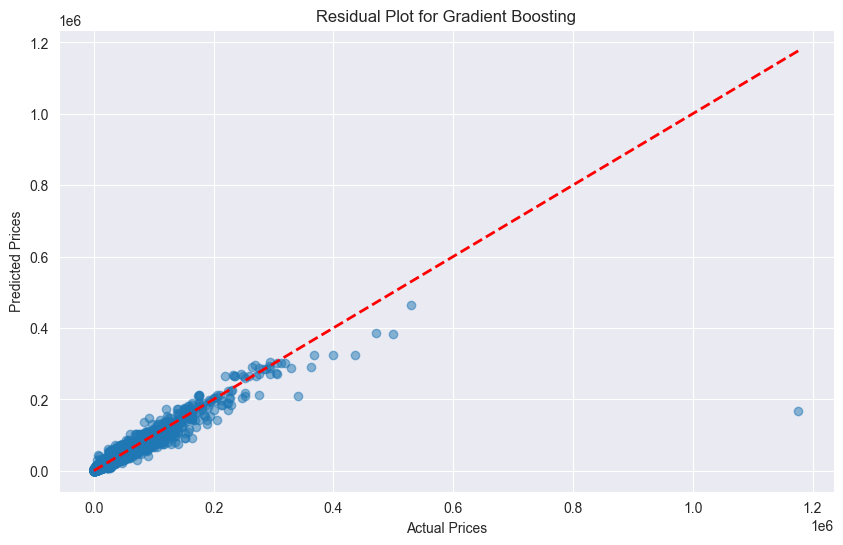

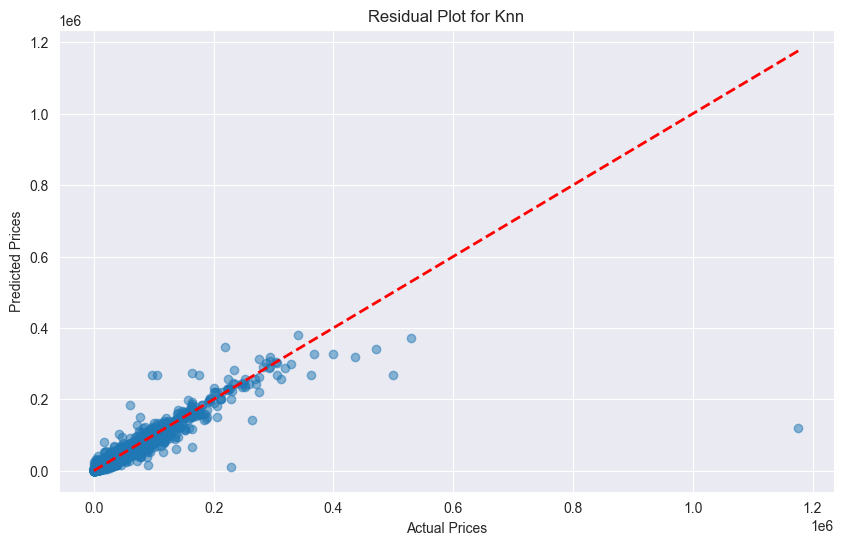

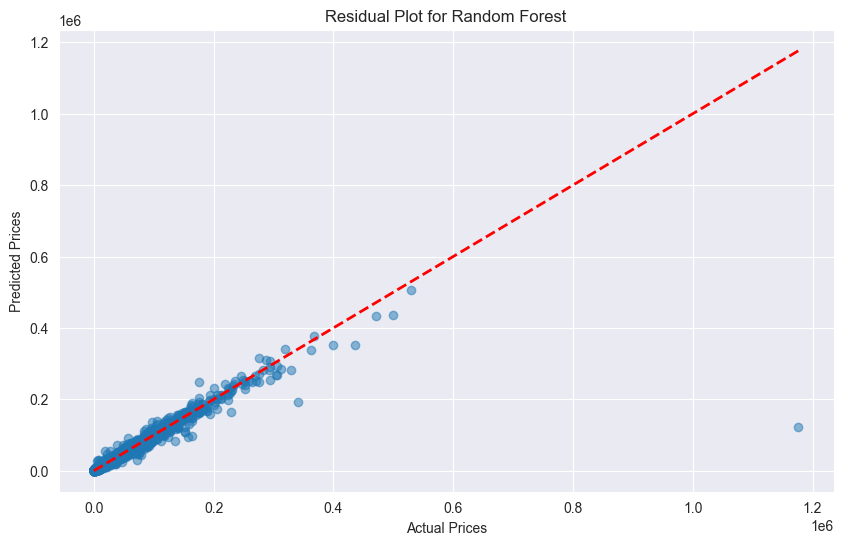

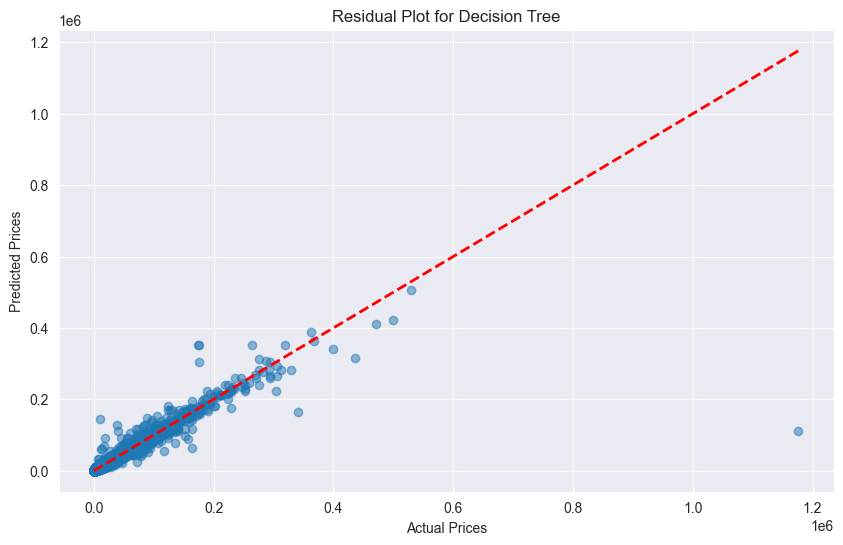

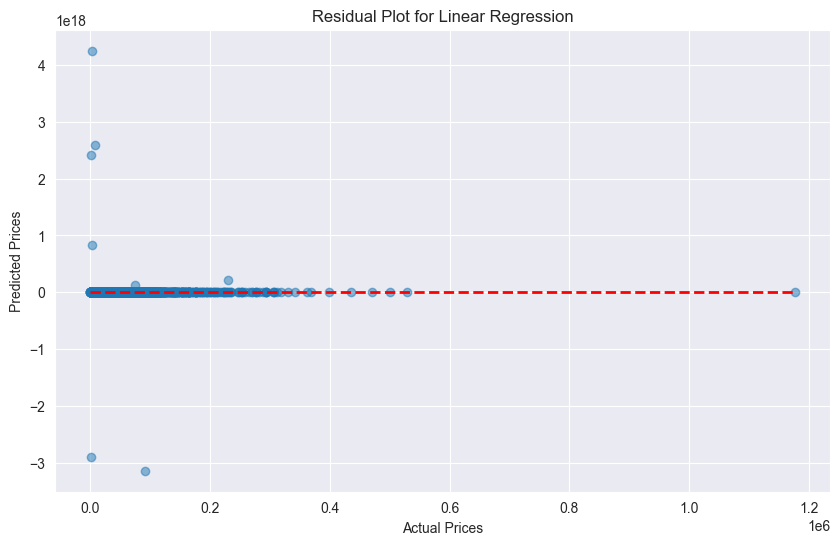

In [24]:
import matplotlib.pyplot as plt

def plot_residuals(models, X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)
        plt.title(f'Residual Plot for {name}')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.grid(True)
        plt.savefig(f'residual_plot_{name.lower().replace(" ", "_")}.png')
        plt.show()

plot_residuals(models, X_test, y_test)


In [25]:
def add_predictions_to_data(models, X_test, y_test, original_data, feature_names):
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    original_data_test = original_data.iloc[X_test_df.index].copy()

    for name, model in models.items():
        original_data_test[f'{name}_Prediction'] = model.predict(X_test)

    return original_data_test

updated_data = add_predictions_to_data(models, X_test, y_test, original_data, feature_names)
updated_data.to_csv('Ad_table_with_predictions.csv', index=False)
